In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score
import pickle
import warnings
warnings.filterwarnings("ignore")

In [6]:
with open('dataset-nids.pkl','rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3549974, 7), (3549974,), (508003, 7), (508003,))

Tuning best parameters

In [14]:
%%time 

param_grid = {
    "C": [1,5,10],
    "gamma": [0.1, 1, 10],
    "max_iter": [1000, 5000,10000]

}

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
cf_svm = GridSearchCV(SVC(),param_grid=param_grid, scoring="precision", cv=3, verbose=2)
cf_svm.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ......................C=1, gamma=0.1, max_iter=1000; total time=10.3min
[CV] END ......................C=1, gamma=0.1, max_iter=1000; total time=10.2min
[CV] END ......................C=1, gamma=0.1, max_iter=1000; total time=10.2min
[CV] END ......................C=1, gamma=0.1, max_iter=5000; total time=50.6min
[CV] END ......................C=1, gamma=0.1, max_iter=5000; total time=53.2min
[CV] END ......................C=1, gamma=0.1, max_iter=5000; total time=51.3min
[CV] END ....................C=1, gamma=0.1, max_iter=10000; total time=101.2min
[CV] END ...................C=1, gamma=0.1, max_iter=10000; total time=1707.1min
[CV] END ....................C=1, gamma=0.1, max_iter=10000; total time=112.9min
[CV] END ........................C=1, gamma=1, max_iter=1000; total time=11.4min
[CV] END ........................C=1, gamma=1, max_iter=1000; total time=11.1min
[CV] END ........................C=1, gamma=1, m

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'gamma': [0.1, 1, 10],
                         'max_iter': [1000, 5000, 10000]},
             scoring='precision', verbose=2)

In [20]:

params = cf_svm.best_params_
score = cf_svm.best_score_

In [21]:
print(params)
print(score)

{'C': 5, 'gamma': 1, 'max_iter': 5000}
0.981692144186073


Baseline

In [5]:
svm = SVC(C = 5, gamma = 1, kernel = "rbf",verbose=3, max_iter=10000,probability=True)
svm_cls = svm.fit(X_train, y_train)

[LibSVM]

In [6]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import scikitplot as skplt 
import matplotlib.pyplot as plt

Text(0, 0.5, 'Valores Reais ')

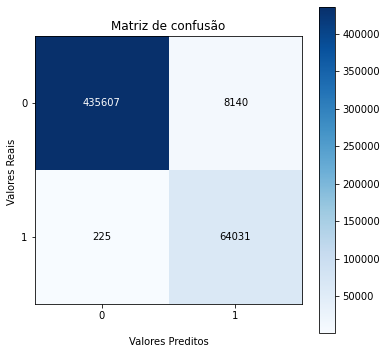

In [7]:
y_pred_opt = svm_cls.predict(X_test)
ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred_opt, figsize=(6,6))
ax.set_title('Matriz de confusão')
ax.set_xlabel('\nValores Preditos')
ax.set_ylabel('Valores Reais ')

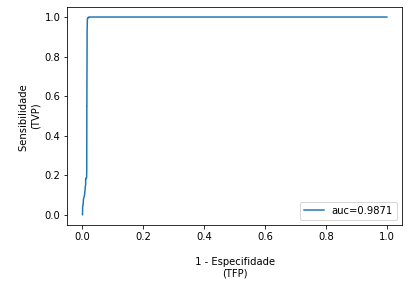

In [8]:
y_pred_proba = svm_cls.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(round(auc,4)))
plt.ylabel('\nSensibilidade \n(TVP)')
plt.xlabel('\n 1 - Especifidade \n(TFP)')
plt.legend(loc=4)
plt.show()

Cross Validation

In [8]:
X_train = np.concatenate((X_train,X_test), axis = 0)
y_train = np.concatenate((y_train,y_test), axis = 0)

In [10]:
X_train.shape, y_train.shape

((4057977, 7), (4057977,))

In [1]:
from sklearn.model_selection import KFold, cross_validate

In [9]:

metricas = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc' ]
svm = SVC(C = 10, gamma = 1, kernel = "rbf",verbose=3, max_iter = 1000, probability=True)
metricas = cross_validate(svm, X_train, y_train, cv=10, scoring= metricas)

for met in metricas:
    print(f"- {met}:")
    print(f"-- {metricas[met]}")
    print(f"-- {np.mean(metricas[met])} +- {np.std(metricas[met])}\n")  

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]- fit_time:
-- [ 7123.97610331  6853.19661903  7263.48540545  7369.24089193
  6980.76521444  6641.37022305  6615.23383284 38950.52312827
  7710.41624546  6294.42153001]
-- 10180.262919378281 +- 9598.007361035374

- score_time:
-- [326.92971158 315.98996639 329.59757805 317.12592864 271.1079936
 292.04500651 325.43339705 330.49928641 347.44777107 273.51180673]
-- 312.9688446044922 +- 24.282303475033878

- test_accuracy:
-- [0.91272012 0.91334358 0.91301584 0.91307744 0.91382412 0.91331894
 0.91380441 0.91397916 0.91339512 0.91270759]
-- 0.9133186314574896 +- 0.0004261115280280224

- test_precision:
-- [0.9902871  0.99053611 0.99053428 0.99120366 0.99081988 0.99083338
 0.9912662  0.99094006 0.99071216 0.99084425]
-- 0.9907977074687695 +- 0.00028536885461558374

- test_recall:
-- [0.8154292  0.81660903 0.81588047 0.81545638 0.81744189 0.81630556
 0.81702324 0.81768557 0.81657641 0.81493443]
-- 0.81633421914992